# Análisis de Indicadores de Rendimiento

**Objetivo:** Evaluar el rendimiento de la aplicación mediante el análisis de métricas clave extraídas de la base de datos.

Este reporte transforma los datos crudos en información accionable para identificar:
1. Tendencias de uso.
2. Estructura del contenido educativo.
3. Niveles de engagement de los usuarios.

In [2]:
pip install pandas matplotlib

  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 8.4 MB/s eta 0:00:000:00:01m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 7.8 MB/s eta 0:00:008.9 MB/s eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 7.2 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.0 MB/s eta 0:00:009.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 8.4 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 8.1 MB/s eta 0:00:009.6 MB/s eta 0:00:01
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.3
[n

In [3]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Opcional: Para gráficos más estéticos

# Configuración de estilo
plt.style.use('ggplot') 
plt.rcParams['figure.figsize'] = (10, 6)

# Carga de datos
try:
    droped_df = pd.read_csv("P20242_Inst_1_clean.csv")
    print("Datos cargados correctamente.")
    print(f"Registros totales: {droped_df.shape[0]}")
except FileNotFoundError:
    print("Error: El archivo 'cleaned_data.csv' no se encuentra.")

Datos cargados correctamente.
Registros totales: 1162146


## 1. Resumen de Métricas Globales
Vista general del volumen de usuarios y contenido disponible en la plataforma.

In [2]:
# Cálculos básicos
unique = droped_df[['page', 'artifact']].drop_duplicates().reset_index(drop=True)
total_artifacts = unique.groupby('page').size().reset_index(name='artifact_count')
unique_pages = droped_df[['chapter', 'page']].drop_duplicates().reset_index(drop=True)
total_pages_per_chapter = unique_pages.groupby('chapter').size().reset_index(name='pages')
pages_to_chapter = droped_df[['chapter', 'page']].drop_duplicates().reset_index(drop=True)



usuarios_unicos = droped_df['_idUser'].nunique()
total_capitulos = droped_df['chapter'].nunique()
paginas_unicas = total_pages_per_chapter['pages'].sum()
artefactos_unicos = total_artifacts.merge(pages_to_chapter, on='page', how='left').groupby('chapter')['artifact_count'].sum().reset_index(name='artifacts')['artifacts'].sum()

# Mostrar KPIs
print(f"--- KPIs Principales ---")
print(f"Usuarios Únicos: {usuarios_unicos}")
print(f"Capítulos Totales: {total_capitulos}")
print(f"Páginas Totales: {paginas_unicas}")
print(f"Artefactos Únicos: {artefactos_unicos}")

--- KPIs Principales ---
Usuarios Únicos: 1079
Capítulos Totales: 2
Páginas Totales: 48
Artefactos Únicos: 399


## 2. Estructura del Contenido
Analizamos cómo se distribuye el contenido educativo a través de los capítulos. Esto nos ayuda a entender la carga de trabajo teórica para el estudiante.

In [3]:
# Cálculos de páginas y artefactos por capítulo

unique_artifacts = droped_df[['page', 'artifact']].drop_duplicates().reset_index(drop=True)
total_artifacts = unique_artifacts.groupby('page').size().reset_index(name='artifact_count')

# Unir para obtener artefactos por capítulo
pages_to_chapter = droped_df[['chapter', 'page']].drop_duplicates().reset_index(drop=True)
total_artifacts_per_chapter = total_artifacts.merge(pages_to_chapter, on='page', how='left')\
                                             .groupby('chapter')['artifact_count'].sum()\
                                             .reset_index(name='artifacts')

print("Distribución de contenido por capítulo:")
display(total_pages_per_chapter.head()) # Use display() si está en Jupyter

Distribución de contenido por capítulo:


,chapter,pages
0,0,7
1,1,41


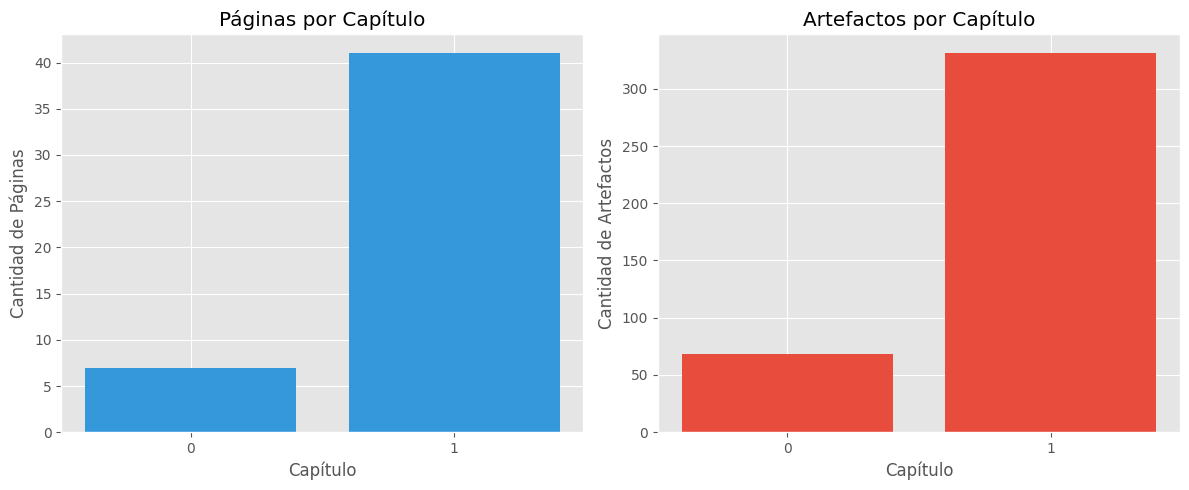

In [4]:
# Gráfico: Páginas por Capítulo
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(total_pages_per_chapter['chapter'].astype(str), total_pages_per_chapter['pages'], color='#3498db')
plt.title('Páginas por Capítulo')
plt.xlabel('Capítulo')
plt.ylabel('Cantidad de Páginas')

# Gráfico: Artefactos por Capítulo
plt.subplot(1, 2, 2)
plt.bar(total_artifacts_per_chapter['chapter'].astype(str), total_artifacts_per_chapter['artifacts'], color='#e74c3c')
plt.title('Artefactos por Capítulo')
plt.xlabel('Capítulo')
plt.ylabel('Cantidad de Artefactos')

plt.tight_layout()
plt.show()

## 3. Comportamiento y Progreso del Usuario
Evaluamos qué tan lejos llegan los usuarios. ¿Completan todos los capítulos o abandonan al principio?

In [5]:
# Capítulos y Páginas por Usuario
chapters_per_user = droped_df.groupby('_idUser')['chapter'].nunique().reset_index(name='chapters')
pages_per_user = droped_df.groupby('_idUser')['page'].nunique().reset_index(name='pages')

# Promedios
avg_chapters = chapters_per_user['chapters'].mean()
avg_pages = pages_per_user['pages'].mean()

print(f"Promedio de capítulos visitados por usuario: {avg_chapters:.2f}")
print(f"Promedio de páginas visitadas por usuario: {avg_pages:.2f}")

Promedio de capítulos visitados por usuario: 1.80
Promedio de páginas visitadas por usuario: 32.66


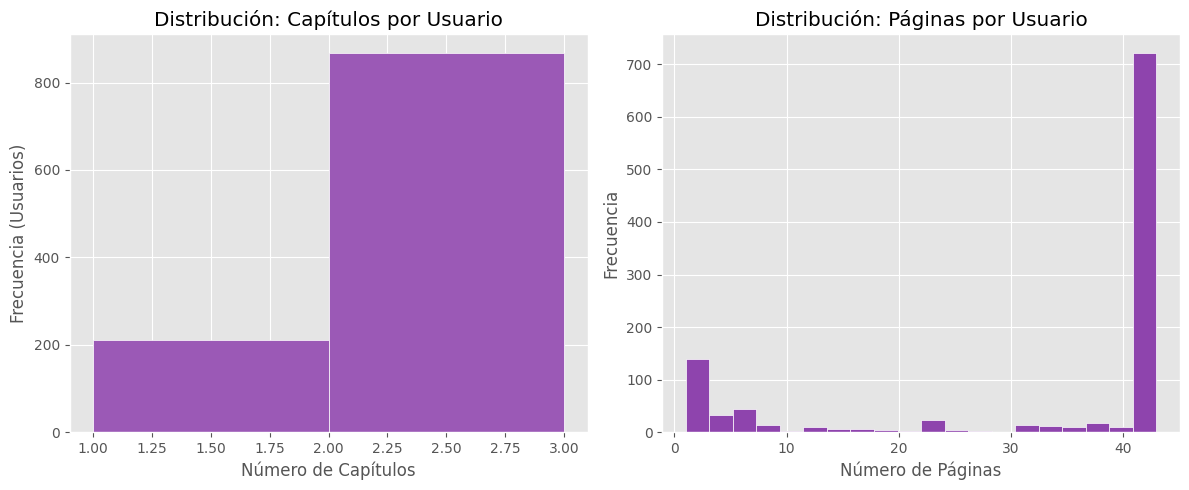

In [6]:
# Histogramas de Progreso
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(chapters_per_user['chapters'], bins=range(1, int(chapters_per_user['chapters'].max()) + 2), 
         edgecolor='white', color='#9b59b6')
plt.title('Distribución: Capítulos por Usuario')
plt.xlabel('Número de Capítulos')
plt.ylabel('Frecuencia (Usuarios)')

plt.subplot(1, 2, 2)
plt.hist(pages_per_user['pages'], bins=20, edgecolor='white', color='#8e44ad')
plt.title('Distribución: Páginas por Usuario')
plt.xlabel('Número de Páginas')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

## 4. Interacción y Reintentos
Analizamos la cantidad de ejercicios completados y los reintentos (artefactos repetidos), lo cual puede ser un indicador de la dificultad del contenido o del compromiso del usuario.

In [7]:
# Ejercicios completos
ejercicios_completos = droped_df[droped_df['validationArtifact'] == True].groupby('_idUser').size().reset_index(name='completed')

# Reintentos (Artefactos repetidos)
artifact_counts = droped_df.groupby(['_idUser', 'artifact']).size().reset_index(name='count')
reintentos = artifact_counts[artifact_counts['count'] > 1].copy()
reintentos['reintentos_count'] = reintentos['count'] - 1
total_reintentos = reintentos.groupby('_idUser')['reintentos_count'].sum().reset_index(name='total_reintentos')

print(f"Promedio de ejercicios completados: {ejercicios_completos['completed'].mean():.2f}")
print(f"Promedio de reintentos por usuario: {total_reintentos['total_reintentos'].mean():.2f}")

Promedio de ejercicios completados: 376.02
Promedio de reintentos por usuario: 1078.07


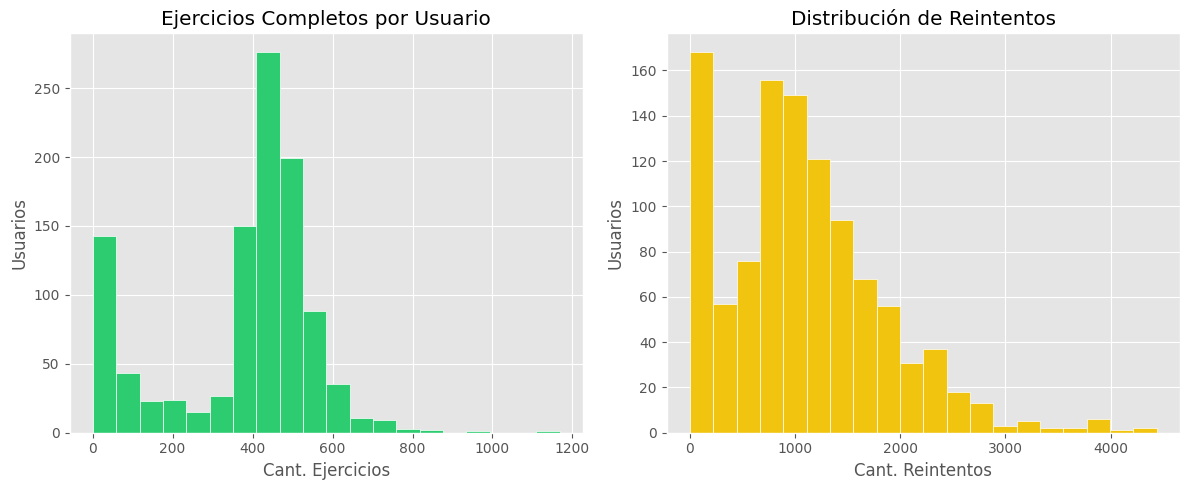

In [8]:
plt.figure(figsize=(12, 5))

# Ejercicios Completos
plt.subplot(1, 2, 1)
plt.hist(ejercicios_completos['completed'], bins=20, edgecolor='white', color='#2ecc71')
plt.title('Ejercicios Completos por Usuario')
plt.xlabel('Cant. Ejercicios')
plt.ylabel('Usuarios')

# Reintentos
plt.subplot(1, 2, 2)
plt.hist(total_reintentos['total_reintentos'], bins=20, edgecolor='white', color='#f1c40f')
plt.title('Distribución de Reintentos')
plt.xlabel('Cant. Reintentos')
plt.ylabel('Usuarios')

plt.tight_layout()
plt.show()

## 5. Tiempo por unidad

Al analizar las horas totales consumidas por unidad, se puede determinar el "peso" real de cada sección dentro del curso. Este indicador es vital para detectar cuellos de botella: las páginas o capítulos con picos de horas consumidas sugieren puntos donde los estudiantes se detienen más, ya sea por complejidad pedagógica o porque el contenido es altamente relevante para ellos.

In [9]:
# Cálculos de segundos
total_seconds_per_chapter = droped_df.groupby('chapter')['seconds'].sum().reset_index(name='total_seconds')
total_seconds_per_page = droped_df.groupby('page')['seconds'].sum().reset_index(name='total_seconds')

print("Horas consumidas por capítulo:\n", total_seconds_per_chapter.assign(total_hours=total_seconds_per_chapter['total_seconds'] / 3600))
print("Horas consumidas por página:\n", total_seconds_per_page.assign(total_hours=total_seconds_per_page['total_seconds'] / 3600))

Horas consumidas por capítulo:
    chapter  total_seconds   total_hours
0        0       19280073   5355.575833
1        1       37909541  10530.428056
Horas consumidas por página:
     page  total_seconds  total_hours
0    1.0        2210761   614.100278
1    1.1        3298853   916.348056
2    2.0        4260252  1183.403333
3    2.1        3050365   847.323611
4    3.0        3177939   882.760833
5    3.1          77342    21.483889
6    4.0        1611702   447.695000
7    5.0        3709239  1030.344167
8    6.0        5168030  1435.563889
9    7.0         261738    72.705000
10   8.0        1311647   364.346389
11   9.0         394885   109.690278
12  10.0        1145487   318.190833
13  10.1         638670   177.408333
14  11.0         866275   240.631944
15  12.0        1176706   326.862778
16  13.0        1423052   395.292222
17  14.0         824690   229.080556
18  14.1         617263   171.461944
19  15.0         632389   175.663611
20  16.0         578638   160.732778
21  

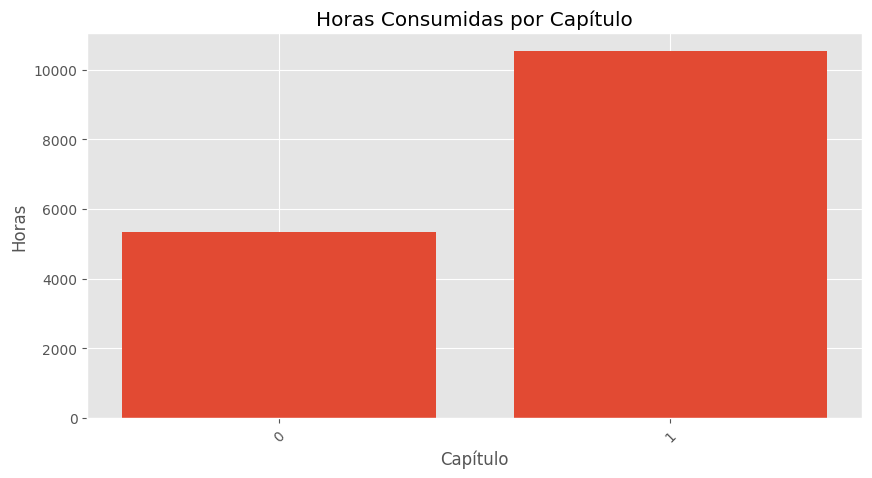

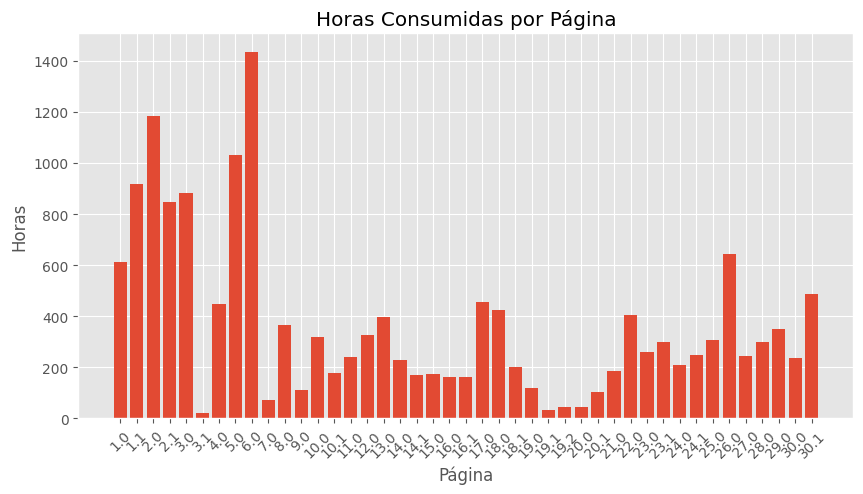

In [10]:
# Gráfico de horas consumidas por capítulo
plt.figure(figsize=(10, 5))
plt.bar(total_seconds_per_chapter['chapter'].astype(str), total_seconds_per_chapter['total_seconds'] / 3600)
plt.title('Horas Consumidas por Capítulo')
plt.xlabel('Capítulo')
plt.ylabel('Horas')
plt.xticks(rotation=45)
plt.show()

# Gráfico de horas consumidas por página
plt.figure(figsize=(10, 5))
plt.bar(total_seconds_per_page['page'].astype(str), total_seconds_per_page['total_seconds'] / 3600)
plt.title('Horas Consumidas por Página')
plt.xlabel('Página')
plt.ylabel('Horas')
plt.xticks(rotation=45)
plt.show()


# Comportamiento del tiempo


In [11]:
media = droped_df["seconds"].mean()
variacion = droped_df["seconds"].std()


limite = media +  2 * variacion 
print("La media es de: ", media)
print("La variacion estandar: ", variacion)

df_filtered = droped_df[droped_df['seconds'] <= limite].copy()
# df_filtered.to_csv('output.csv', index=False)


La media es de:  49.21035222768912
La variacion estandar:  193.16735802815361


El uso de la media (μ) y la desviación estándar (σ) es un método estadístico fundamental y ampliamente adoptado para la detección y gestión de valores atípicos (outliers) en un conjunto de datos. Al filtrar las entradas que se pasen de dos veces la variacion estandar más la media podemos descartar las anomalias que se encuentran en el 5% de la distribucion.

# Comportamiento por artefacto


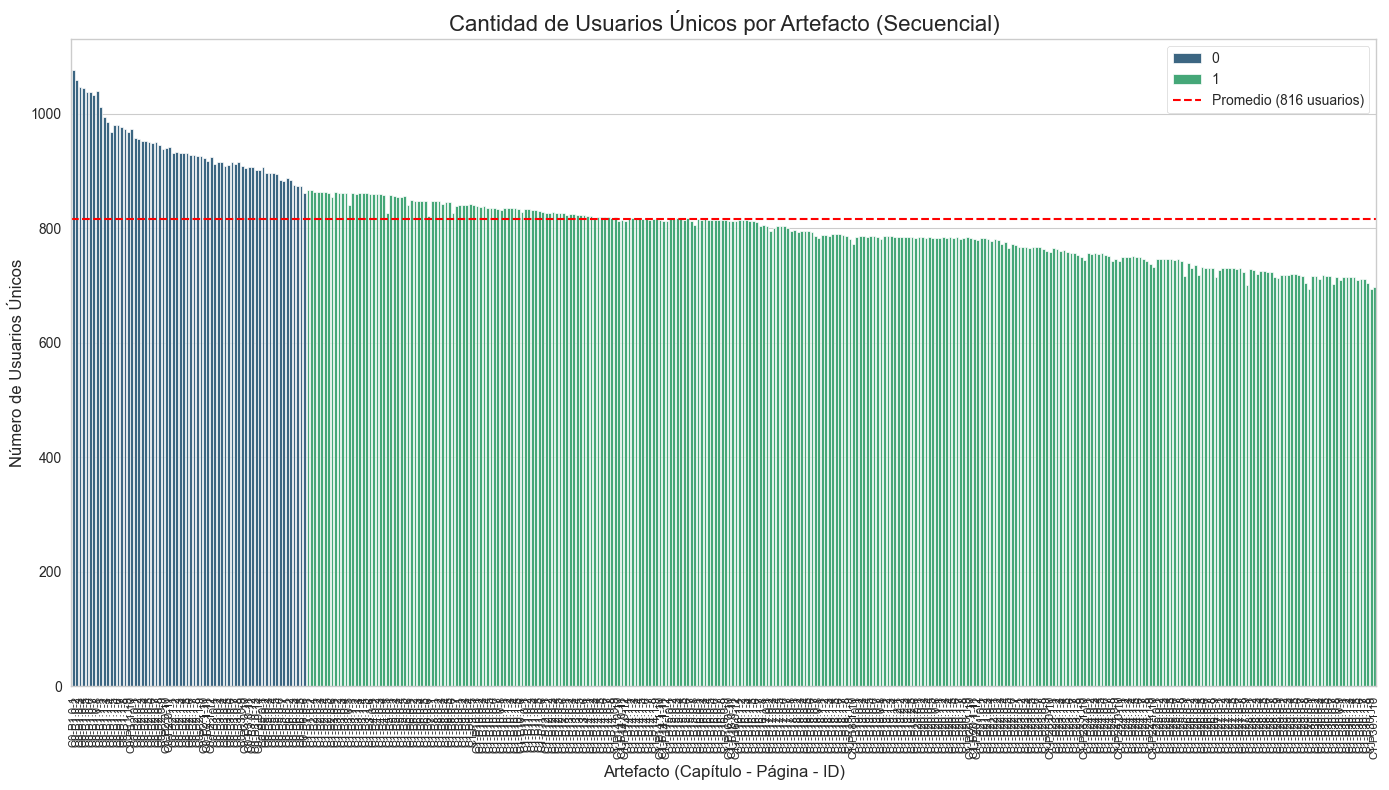

In [12]:

# 1. Preparación de los datos
# Agrupamos por capítulo, página y artefacto, contando usuarios únicos
interaction_counts = droped_df.groupby(['chapter', 'page', 'artifact'])['_idUser'].nunique().reset_index()
interaction_counts.rename(columns={'_idUser': 'unique_users'}, inplace=True)

# Creamos una etiqueta compuesta para el eje X (Ej: C1-P1.1-ArtA)
# Esto ayuda a que la gráfica sea legible si hay muchos artefactos
interaction_counts['label'] = (
    "C" + interaction_counts['chapter'].astype(str) + 
    "-P" + interaction_counts['page'].astype(str) + 
    "-" + interaction_counts['artifact'].astype(str)
)

# Ordenamos para mantener la secuencia lógica del curso
interaction_counts.sort_values(by=['chapter', 'page', 'artifact'], inplace=True)

# 2. Configuración de la Gráfica
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Crear el gráfico de barras
barplot = sns.barplot(
    data=interaction_counts,
    x='label',
    y='unique_users',
    hue='chapter',  # Colorear por capítulo para distinguir secciones visualmente
    dodge=False,    # Las barras se mantienen alineadas
    palette='viridis'
)

# 3. Personalización
plt.title('Cantidad de Usuarios Únicos por Artefacto (Secuencial)', fontsize=16)
plt.xlabel('Artefacto (Capítulo - Página - ID)', fontsize=12)
plt.ylabel('Número de Usuarios Únicos', fontsize=12)

# Rotar las etiquetas del eje X para que no se superpongan
plt.xticks(rotation=90, fontsize=8)

# Añadir una línea de promedio para referencia
avg_users = interaction_counts['unique_users'].mean()
plt.axhline(avg_users, color='red', linestyle='--', label=f'Promedio ({int(avg_users)} usuarios)')
plt.legend()

plt.tight_layout()
plt.show()

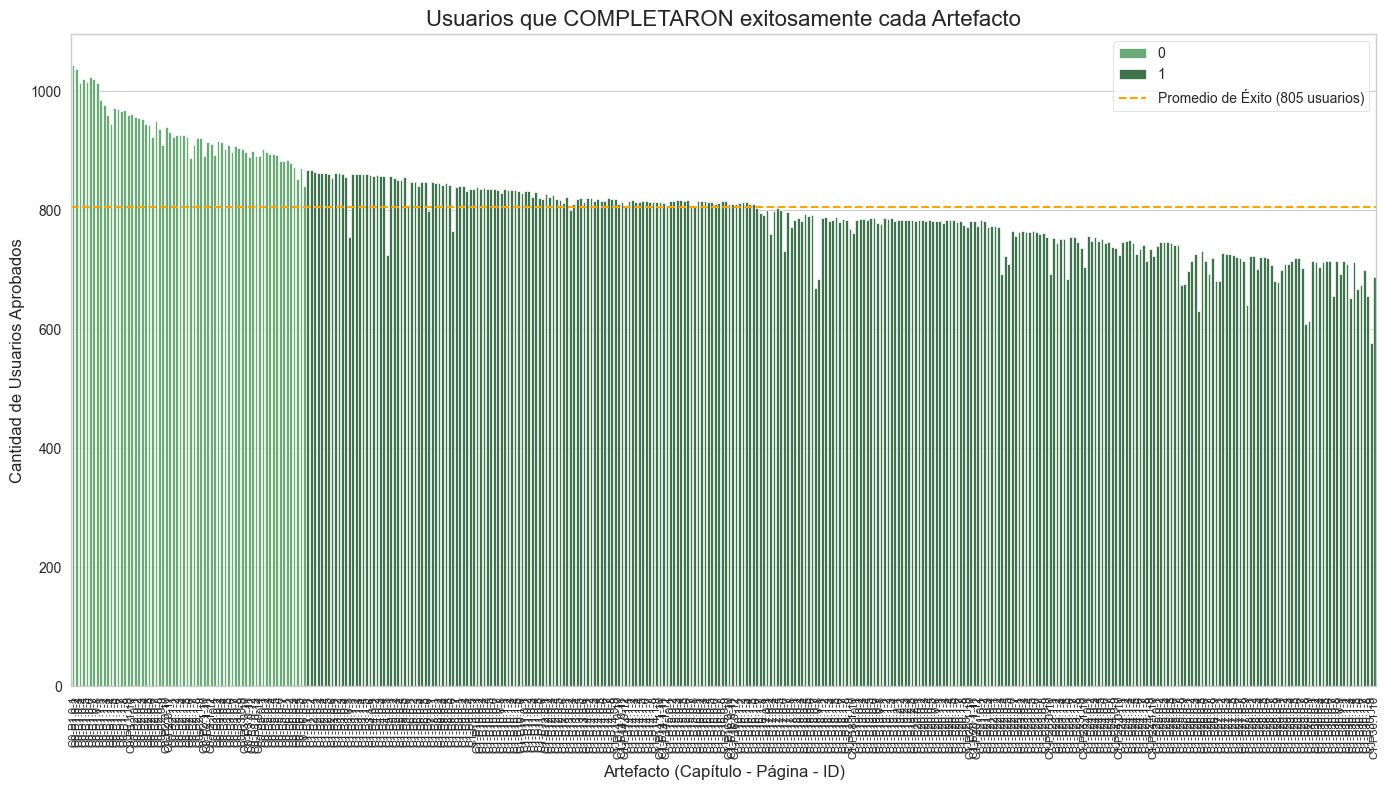

In [13]:

# 1. Filtrado y Preparación
# Filtramos solo donde validationArtifact es True (el usuario resolvió el ejercicio)
completed_data = droped_df[droped_df['validationArtifact'] == True]

# Agrupamos por jerarquía
success_counts = completed_data.groupby(['chapter', 'page', 'artifact'])['_idUser'].nunique().reset_index()
success_counts.rename(columns={'_idUser': 'successful_users'}, inplace=True)

# Crear etiqueta legible (C#-P#-Art#)
success_counts['label'] = (
    "C" + success_counts['chapter'].astype(str) + 
    "-P" + success_counts['page'].astype(str) + 
    "-" + success_counts['artifact'].astype(str)
)

# Ordenar secuencialmente
success_counts.sort_values(by=['chapter', 'page', 'artifact'], inplace=True)

# 2. Configuración de la Gráfica
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Usamos una paleta de verdes para denotar "éxito"
success_plot = sns.barplot(
    data=success_counts,
    x='label',
    y='successful_users',
    hue='chapter',
    dodge=False,
    palette='Greens_d' # Paleta verde oscura
)

# 3. Personalización
plt.title('Usuarios que COMPLETARON exitosamente cada Artefacto', fontsize=16)
plt.xlabel('Artefacto (Capítulo - Página - ID)', fontsize=12)
plt.ylabel('Cantidad de Usuarios Aprobados', fontsize=12)
plt.xticks(rotation=90, fontsize=8)

# Línea de promedio de aprobados
avg_success = success_counts['successful_users'].mean()
plt.axhline(avg_success, color='orange', linestyle='--', label=f'Promedio de Éxito ({int(avg_success)} usuarios)')
plt.legend()

plt.tight_layout()
plt.show()

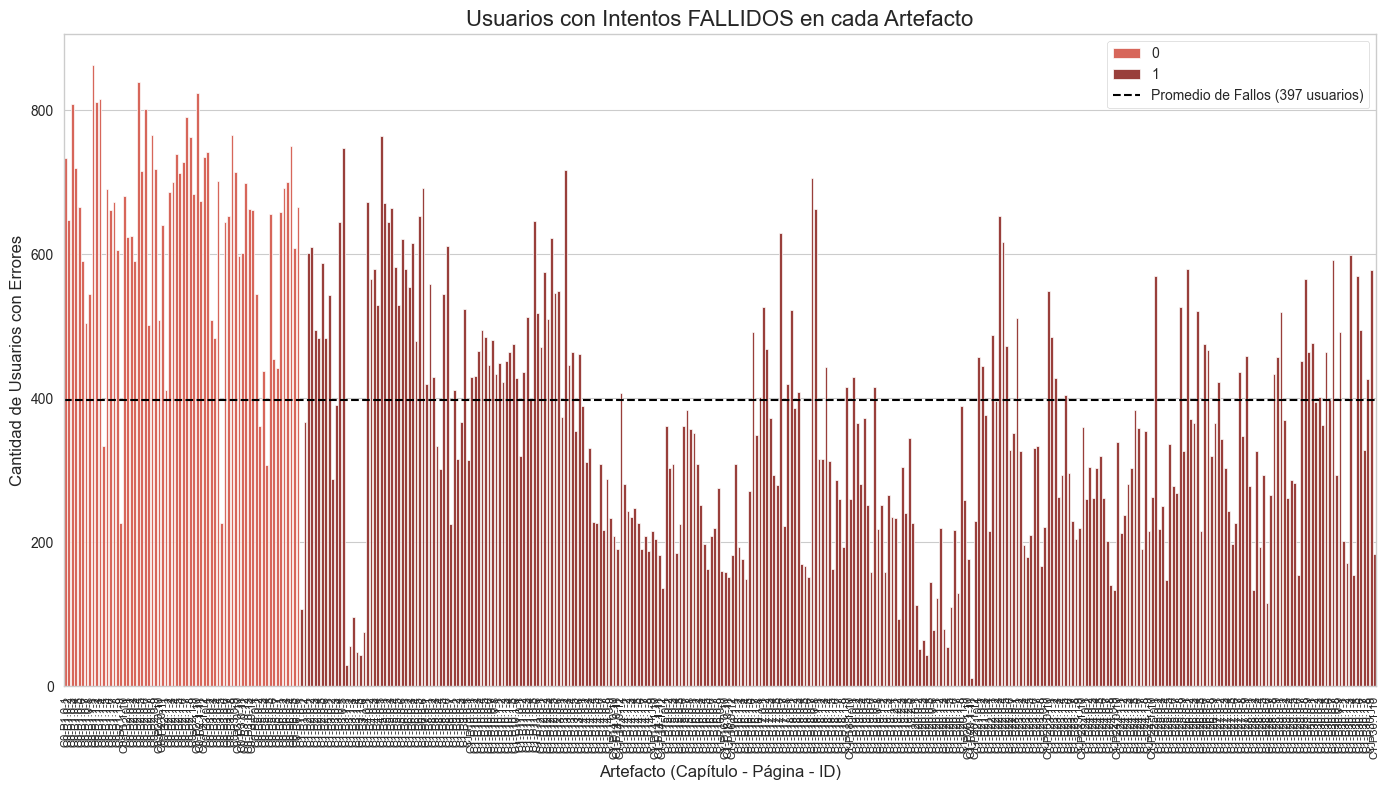

In [14]:

# 1. Filtrado y Preparación
# Filtramos donde validationArtifact es False (error o incompleto)
failed_data = droped_df[droped_df['validationArtifact'] == False]

# Agrupamos por jerarquía
fail_counts = failed_data.groupby(['chapter', 'page', 'artifact'])['_idUser'].nunique().reset_index()
fail_counts.rename(columns={'_idUser': 'failed_users'}, inplace=True)

# Crear etiqueta legible
fail_counts['label'] = (
    "C" + fail_counts['chapter'].astype(str) + 
    "-P" + fail_counts['page'].astype(str) + 
    "-" + fail_counts['artifact'].astype(str)
)

# Ordenar secuencialmente
fail_counts.sort_values(by=['chapter', 'page', 'artifact'], inplace=True)

# 2. Configuración de la Gráfica
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Usamos una paleta de Rojos para denotar "error/alerta"
fail_plot = sns.barplot(
    data=fail_counts,
    x='label',
    y='failed_users',
    hue='chapter',
    dodge=False,
    palette='Reds_d' # Paleta de rojos oscuros
)

# 3. Personalización
plt.title('Usuarios con Intentos FALLIDOS en cada Artefacto', fontsize=16)
plt.xlabel('Artefacto (Capítulo - Página - ID)', fontsize=12)
plt.ylabel('Cantidad de Usuarios con Errores', fontsize=12)
plt.xticks(rotation=90, fontsize=8)

# Línea de promedio de fallos (para detectar los casos críticos)
avg_fail = fail_counts['failed_users'].mean()
plt.axhline(avg_fail, color='black', linestyle='--', label=f'Promedio de Fallos ({int(avg_fail)} usuarios)')
plt.legend()

plt.tight_layout()
plt.show()

            day  num_artifacts
0    2024-10-25             85
1    2024-10-26            116
2    2024-10-27           1397
3    2024-10-28          16555
4    2024-10-29          41734
..          ...            ...
111  2025-03-14             61
112  2025-03-15              1
113  2025-03-16            260
114  2025-03-17             43
115  2025-03-18             26

[116 rows x 2 columns]


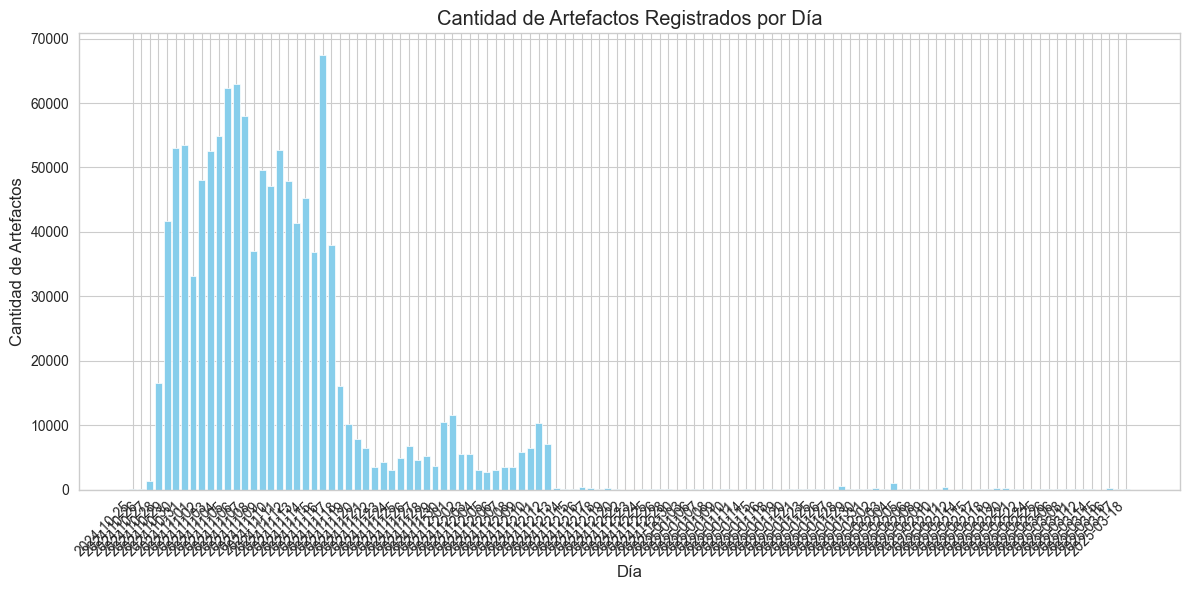

In [17]:
import pandas as pd

# Suponiendo que el DataFrame se llama 'df' y tiene las columnas 'date' y 'artifact'
# --- PASO 1: Asegurarse de que la columna 'date' sea datetime y extraer la fecha
droped_df['date'] = pd.to_datetime(droped_df['date'])
droped_df['day'] = droped_df['date'].dt.date

# --- PASO 2: Contar los artefactos por día
artifacts_per_day = droped_df.groupby('day')['artifact'].count().reset_index()
artifacts_per_day.rename(columns={'artifact': 'num_artifacts'}, inplace=True)

# --- PASO 3: Mostrar el resultado
print(artifacts_per_day)

# Para un gráfico de barras simple (que es más fácil que un "calendar plot" sin bibliotecas especializadas)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(artifacts_per_day['day'].astype(str), artifacts_per_day['num_artifacts'], color='skyblue')
plt.title('Cantidad de Artefactos Registrados por Día')
plt.xlabel('Día')
plt.ylabel('Cantidad de Artefactos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

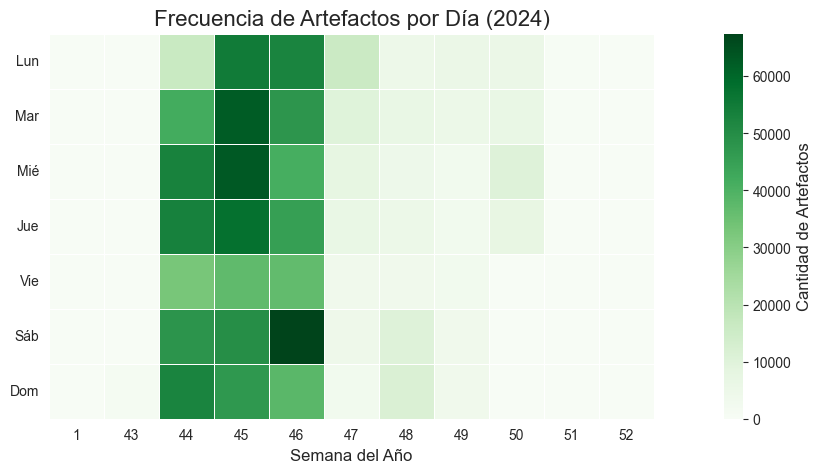

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


    # 1. Conversión de la columna 'date' a formato datetime
droped_df['date'] = pd.to_datetime(df['date'])

    # 2. Agregación: Contar artefactos por día
artifacts_per_day = df.groupby(df['date'].dt.date)['artifact'].count()
artifacts_per_day.index = pd.to_datetime(artifacts_per_day.index)
    
    # 3. Preparación para el Heatmap Calendar
calendar_df = pd.DataFrame(artifacts_per_day)
calendar_df.columns = ['Count']
    
    # Extraer características temporales
calendar_df['DayOfWeek'] = calendar_df.index.dayofweek # Lunes=0, Domingo=6
calendar_df['WeekOfYear'] = calendar_df.index.isocalendar().week.astype(int)
calendar_df['Year'] = calendar_df.index.year
    
    # Seleccionar el año (si hay varios)
year_to_plot = calendar_df['Year'].min()
df_year = calendar_df[calendar_df['Year'] == year_to_plot]

    # Pivotear la tabla: Filas = Día de la Semana, Columnas = Semana del Año
pivot_table = df_year.pivot_table(
    values='Count', 
    index='DayOfWeek', 
    columns='WeekOfYear', 
    fill_value=0
)
    
    # 4. Generación del Heatmap
day_labels = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
pivot_table.index = day_labels

plt.figure(figsize=(18, 5))
    
sns.heatmap(
    pivot_table,
    cmap="Greens", # Color similar a GitHub
    linewidths=0.5,
    linecolor='white',
    square=True,
    cbar_kws={'label': 'Cantidad de Artefactos'},
    yticklabels=day_labels,
    vmax=pivot_table.values.max() 
)
    
plt.title(f'Frecuencia de Artefactos por Día ({year_to_plot})', fontsize=16)
plt.xlabel('Semana del Año')
plt.ylabel('')
plt.yticks(rotation=0)
    
plt.savefig('calendar_heatmap.png')
plt.show()


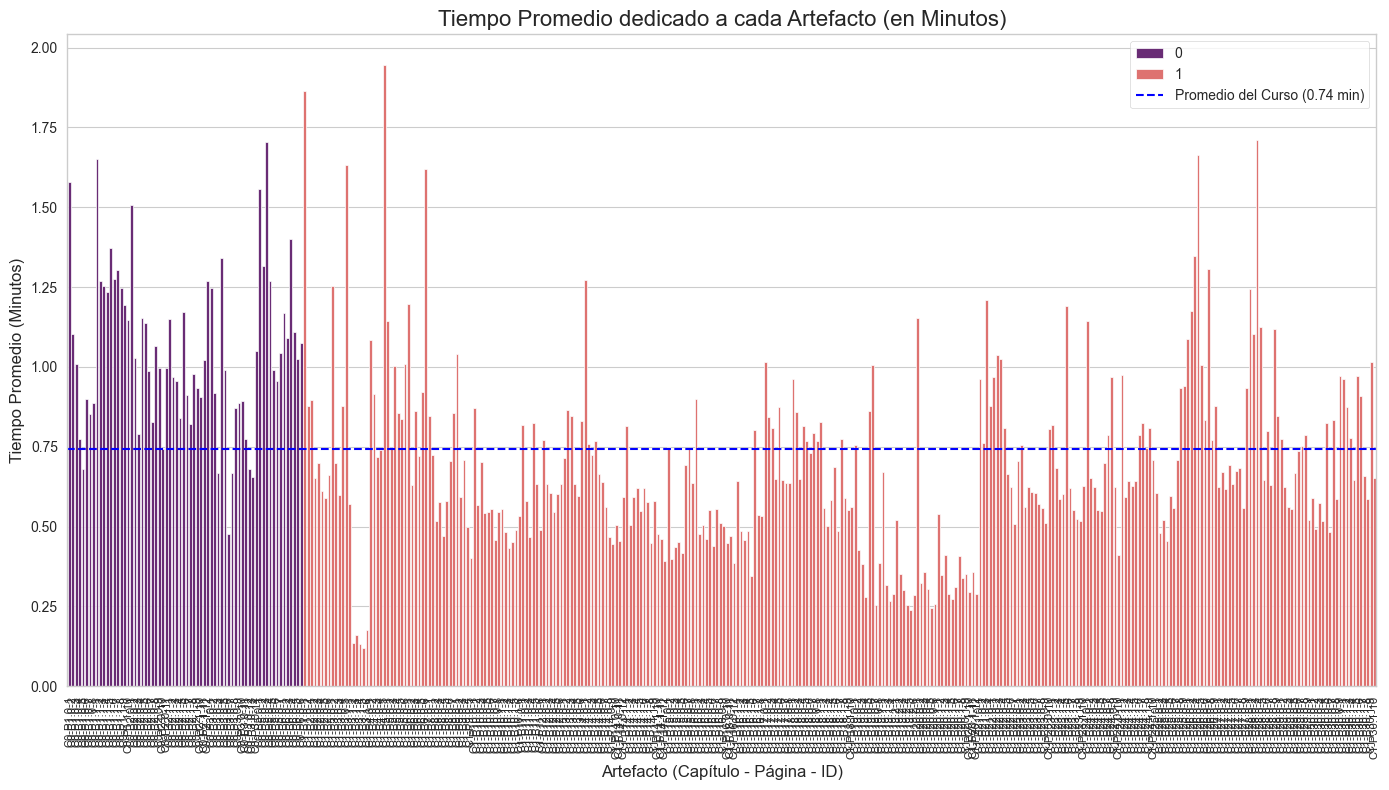

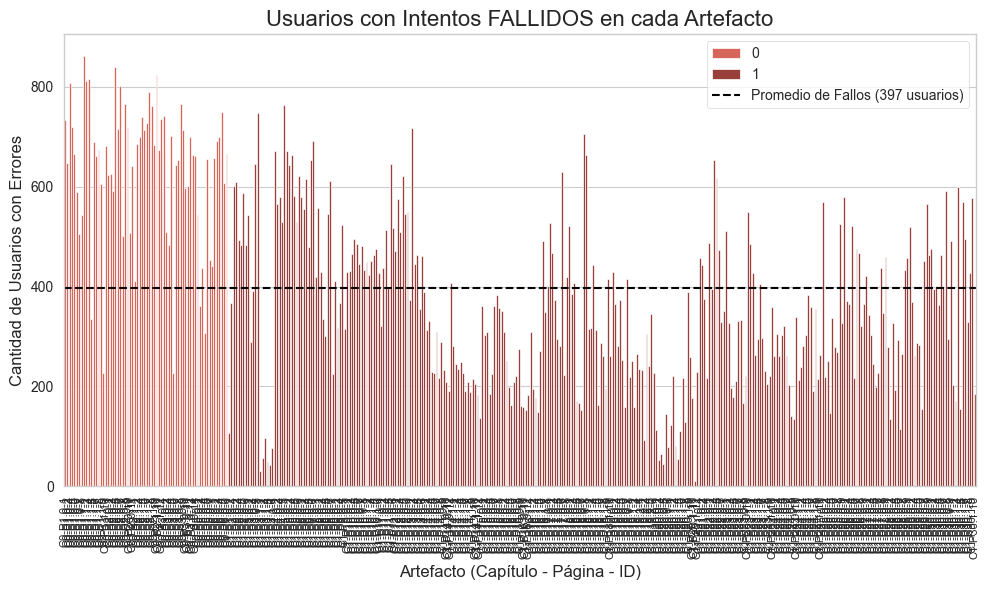

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Preparación de los datos
# Calculamos el promedio de segundos por cada artefacto
time_data = droped_df.groupby(['chapter', 'page', 'artifact'])['seconds'].mean().reset_index()

# Convertimos a minutos para que sea más fácil de leer (Opcional, si prefieres segundos borra la división entre 60)
time_data['minutes'] = time_data['seconds'] / 60

# Creamos la etiqueta compuesta para el eje X
time_data['label'] = (
    "C" + time_data['chapter'].astype(str) + 
    "-P" + time_data['page'].astype(str) + 
    "-" + time_data['artifact'].astype(str)
)

# Ordenamos
time_data.sort_values(by=['chapter', 'page', 'artifact'], inplace=True)

# 2. Configuración de la Gráfica
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Usamos una paleta 'magma' o 'inferno' para denotar intensidad/tiempo
time_plot = sns.barplot(
    data=time_data,
    x='label',
    y='minutes',  # Cambiar a 'seconds' si prefieres la unidad original
    hue='chapter',
    dodge=False,
    palette='magma' 
)

# 3. Personalización
plt.title('Tiempo Promedio dedicado a cada Artefacto (en Minutos)', fontsize=16)
plt.xlabel('Artefacto (Capítulo - Página - ID)', fontsize=12)
plt.ylabel('Tiempo Promedio (Minutos)', fontsize=12)
plt.xticks(rotation=90, fontsize=8)

# Línea de promedio global
avg_time = time_data['minutes'].mean()
plt.axhline(avg_time, color='blue', linestyle='--', label=f'Promedio del Curso ({avg_time:.2f} min)')
plt.legend()

plt.tight_layout()
plt.show()
